In [2]:
import gc
import sys
import warnings
from pathlib import Path
from glob import glob

import os

import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
warnings.simplefilter("ignore")

import lightgbm as lgbm

In [3]:
INPUT_DIR = "../data/input/MovieLens"
OUTPUT_DIR = "../data/output/"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
"""
# kaggle APIからdatasetをzip形式でDownload
# zipファイルをINPUT_DIRに解凍するコード
# 初めの一回のみ動かす

import shutil
shutil.unpack_archive(INPUT_DIR+'movielens-20m-dataset.zip', INPUT_DIR)
"""


"\n# kaggle APIからdatasetをzip形式でDownload\n# zipファイルをINPUT_DIRに解凍するコード\n# 初めの一回のみ動かす\n\nimport shutil\nshutil.unpack_archive(INPUT_DIR+'movielens-20m-dataset.zip', INPUT_DIR)\n"

In [5]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str="{:.3f}[s]", prefix=None, suffix=None, sep=" "):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [6]:
for p in glob(os.path.join(INPUT_DIR, "*")):
    print(p)

../data/input/rating.csv
../data/input/movielens-20m-dataset.zip
../data/input/tag.csv
../data/input/genome_scores.csv
../data/input/genome_tags.csv
../data/input/link.csv
../data/input/movie.csv


In [7]:
def read_csv(file_name, **kwrgs):
    path = os.path.join(INPUT_DIR, file_name+'.csv')
    print(f'Load: {path}')
    return pd.read_csv(path, **kwrgs)

In [8]:
rating = read_csv('rating')
tag = read_csv('tag')
genome_scores = read_csv('genome_scores')
genome_tags = read_csv('genome_tags')
link = read_csv('link')
movie = read_csv('movie')

Load: ../data/input/rating.csv
Load: ../data/input/tag.csv
Load: ../data/input/genome_scores.csv
Load: ../data/input/genome_tags.csv
Load: ../data/input/link.csv
Load: ../data/input/movie.csv


In [9]:
def preprocess_movie(movie):
    df = movie.copy()
    # タイトルとyearの切り離し
    df['release_year'] = df['title'].str.extract("\((\d{4})\)", expand=True)
    df['release_year'] = df['release_year'].astype(str)
    df['title'] = df.title.str[:-7]
    # ジャンルをone-hot-encoding
    df = df.join(df['genres'].str.get_dummies().astype(bool))
    df.drop('genres', axis=1, inplace=True)
    return df

In [10]:
movie_df = preprocess_movie(movie)
movie_df.rename(columns={'(no genres listed)': 'No Genre'}, inplace=True)
movie_df.head()

,movieId,title,release_year,No Genre,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


<Axes: title={'center': 'Number of movies released per year'}, xlabel='release_year'>

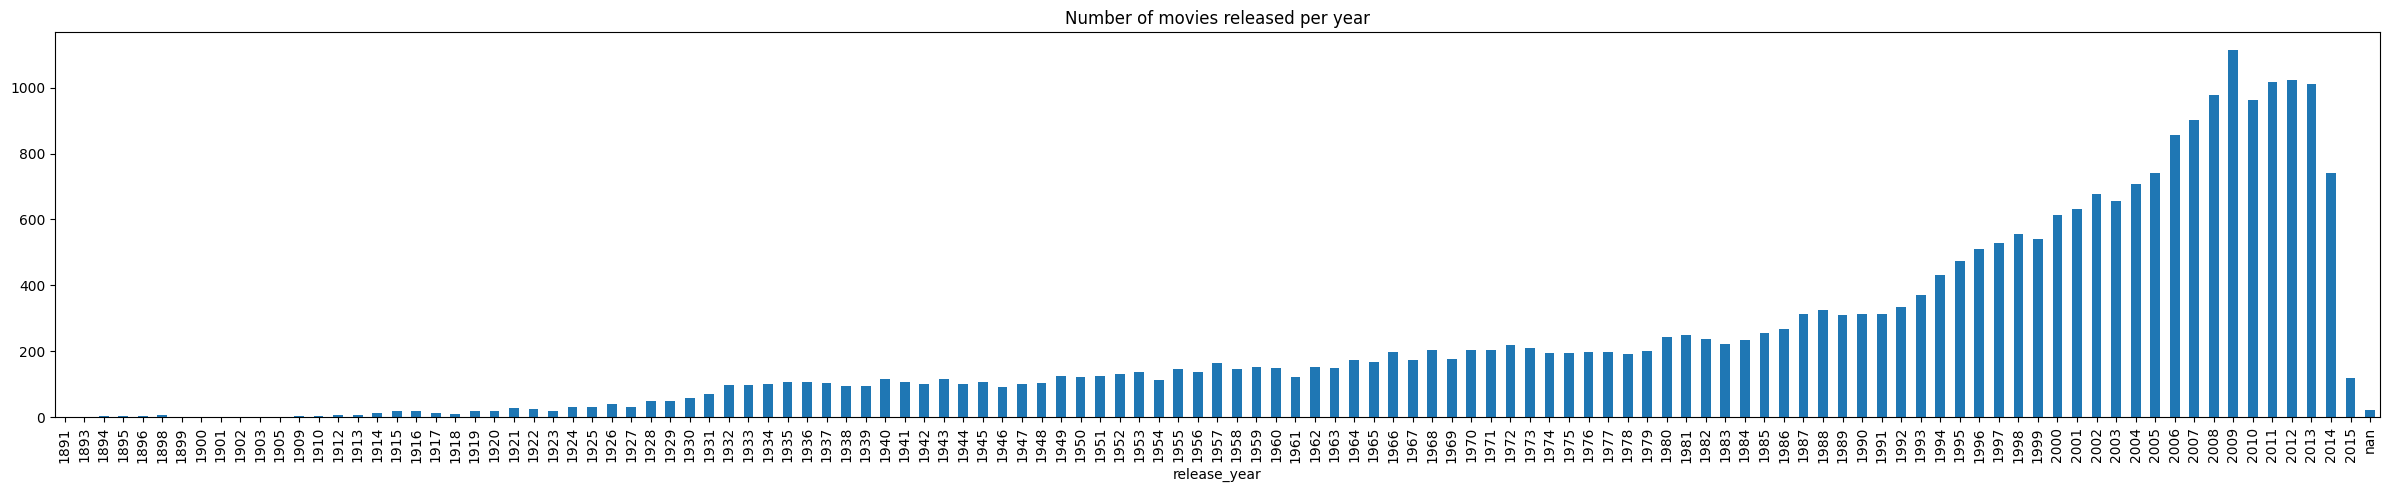

In [11]:
# plot release_year
df_temp = movie_df.groupby(['release_year'])['title'].count()
df_temp.plot.bar(x='year', y='movies', title='Number of movies released per year',
                    figsize=(30, 5))


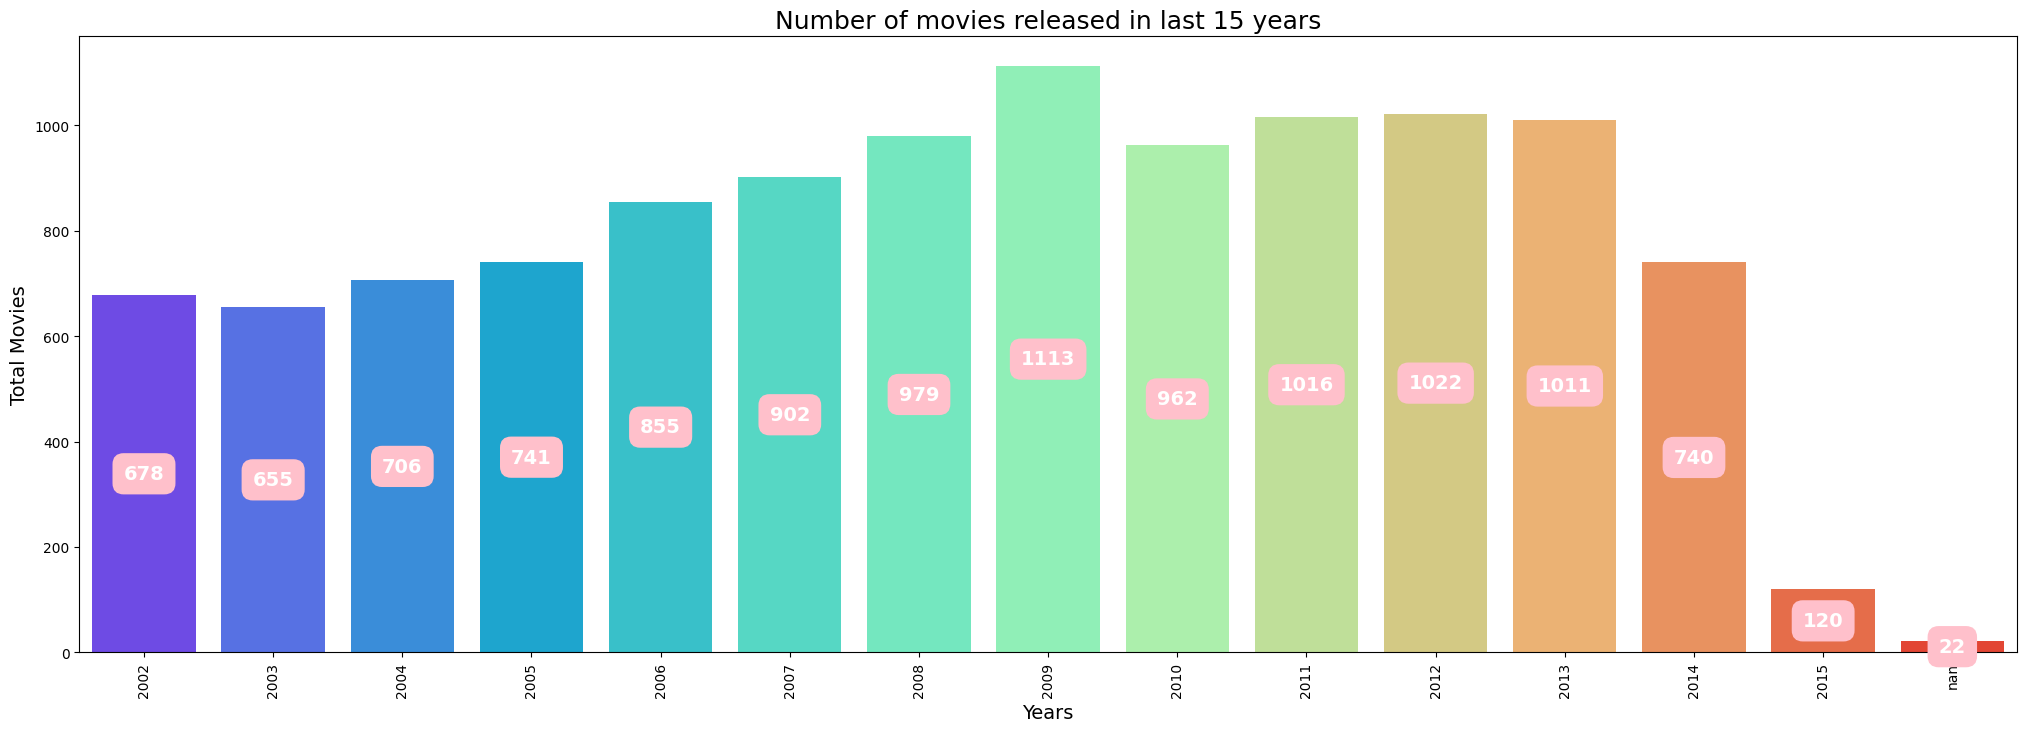

In [12]:
# plot number of movies released in last 15years
df_temp = df_temp.tail(15)
plt.figure(figsize=(25, 8))
ax = sns.barplot(x=df_temp.index, y=df_temp.values,
                data=movie_df, palette='rainbow')

for i in ax.patches:
    ax.text(x = i.get_x() + i.get_width()/2,
            y = i.get_height()/2,
            s = int(i.get_height()),
            ha = 'center', va='center', size=14, weight='bold',
            rotation=0, color='w',
            bbox=dict(boxstyle='round, pad=0.5', fc='pink', ec='pink', lw=2))

plt.xlabel('Years', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Total Movies', fontsize=14)
plt.title('Number of movies released in last 15 years', fontsize=18)
plt.show()